In [1]:
model = "GWTC2_lognormal_low_spin_heavy_mass"
using Cuba
include("events.jl")
using Revise
using Cuba
using HypergeometricFunctions
using SpecialFunctions
using BenchmarkTools
using Interpolations
using Distributions
using KernelDensity
using DelimitedFiles
using StatsPlots
using NestedSamplers
using StatsBase: sample
using Random
# using MCMCChains
using FileIO
using BAT
using IntervalSets
using FileIO
using LaTeXStrings
using Roots
# using GWSC
using IntervalSets
using AbstractMCMC
# AbstractMCMC.setprogress!(false)
Random.seed!(8452);

In [2]:
f = 0.0025693801260000975
mc = 8.896735628637506
σc = 0.9108320383237213
i = 10
j = 30

const m_min = 3
const m_max = 130
const δm = m_max - m_min

127

In [3]:
function mergerRateDensity1st(i, j, mc, σc, f)
    210084.52488130186/(i^2 * j^2 * σc^2) * exp(-(743*σc^4 + 1369*log(i/mc)^2 + 1369*log(j/mc)^2)/(2738*σc^2)) * (i*j)^(3/37) * (i+j)^(36/37) * ((exp(σc^2/2)*f)/mc)^(53/37) * mc^(53/37)
end

function mergerRateDensity2nd1(i, j, mc, σc, f)
    tmp1 = 1009.5488113544313 * f^(69/37) * i^(6/37) * (i+j)^(72/37) / j^(68/37) / σc^3 
    tmp2 = exp(-(-3318*σc^4 + 1369*log(j/mc)^2)/(2738*σc^2))
    
    int0(e) = exp(-(1369*log(e/mc)^2 + 1369*log((-e+i)/mc)^2)/(2738*σc^2)) / (e^2 * (-e + i)^2)
    int(e) = i * int0(i*e)
    function integrand(x, f)
        f[1] = int(x[1])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    tmp1 * tmp2 * result[1]
end

mergerRateDensity2nd(i, j, mc, σc, f) = 0.5 * (mergerRateDensity2nd1(i, j, mc, σc, f) + mergerRateDensity2nd1(j, i, mc, σc, f))

# function mergerRateDensity(i, j, mc, σc, f)
#     if i >= j
#         mergerRateDensity1st(i, j, mc, σc, f) + mergerRateDensity2nd(i, j, mc, σc, f)
#     else
#         mergerRateDensity(j, i, mc, σc, f)
#     end
# end

mergerRateDensity(i, j, mc, σc, f) = mergerRateDensity1st(i, j, mc, σc, f) + mergerRateDensity2nd(i, j, mc, σc, f)

function merger_rate(mc, σc, f) 
    δm = m_max - m_min
    int(m1, m2) = δm^2 * mergerRateDensity(m_min + δm*m1, m_min + δm*m2, mc, σc, f) 
#     println("p1=$p10, p2=$p20, p3=$p30")
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3)
    0.5*result[1]
end

merger_rate (generic function with 1 method)

In [4]:
# @time mergerRateDensity(i, j, mc, σc, f)
# mergerRateDensity1st(i, j, mc, σc, f)
# @time merger_rate(mc, σc, f)
# mergerRateDensity2nd(i, j, mc, σc, f)
# @time mergerRateDensity2nd(i, j, mc, σc, f)
# @time mergerRateDensity2nd1(i, j, mc, σc, f)

In [5]:
function get_post_func(event)
    post_file = "LIGO-data/masses_source_frame_posterior/GW$(event)_posterior.txt"
    post = readdlm(post_file);
    d1 = fit(MvNormal, transpose(post))
    
    μ1, μ2 = d1.μ
    σ1 = sqrt(d1.Σ[1])
    σ2 = sqrt(d1.Σ[4])
    ρ = d1.Σ[2]/σ1/σ2
    norm = 2pi * sqrt(1 - ρ^2) * σ1 * σ2
    
    post(x1, x2) = 1/norm * exp(- 1/2/(1-ρ^2) * ((x1-μ1)^2/σ1^2 - 2ρ*(x1-μ1)*(x2-μ2)/σ1/σ2 + (x2-μ2)^2/σ2^2))
end

#### 
# vt
const time_O1 = 46.1; # (* days or 48.6 days *)
const time_O2 = 117; #(* days *)
const time_O3a = 149.9 #;(* days *)

function get_VT_GWTC2()
    m1s = m2s = collect(1.0:1.0:136.0)
    vts_O1O2 = (time_O1 + time_O2)/365 * reshape(readdlm("backup/VT_1yr_m1m2_LIGO_O1.txt")[:, 3], length(m1s), length(m1s))
    vts_O3a = (time_O3a)/365 * reshape(readdlm("backup/VT_1yr_m1m2_LIGO_O3.txt")[:, 3], length(m1s), length(m1s))
    vts = vts_O1O2 + vts_O3a
    
    vt_int0 = LinearInterpolation((m1s, m2s), vts)
    
    VT(m1, m2) = vt_int0(m1, m2)
end

get_VT_GWTC2 (generic function with 1 method)

In [6]:
posts = [get_post_func(event) for event in GWTC2_events_low_spin_heavy_mass];
# save("backup/posts_$(model).jld2", Dict("posts" => posts))
# posts = load("backup/posts_$(model).jld2", "posts");

VT = get_VT_GWTC2()

VT (generic function with 1 method)

In [7]:
# function β_func(mc, σc, f)
#     int0(m1, m2) = mergerRateDensity(m1, m2, mc, σc, f) * VT(m1, m2)
#     int(m1, m2) = δm^2 * int0(m_min + δm * m1, m_min + δm * m2)
#     function integrand(x, f)
#         f[1] = int(x[1], x[2])
#     end
#     result, err = cuhre(integrand, rtol=1e-1)
#     0.5 * result[1]
# end

function β_func_1st(mc, σc, f)
    int0(m1, m2) = mergerRateDensity1st(m1, m2, mc, σc, f) * VT(m1, m2)
    int(m1, m2) = δm^2 * int0(m_min + δm * m1, m_min + δm * m2)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    0.5 * result[1]
end

function β_func_2nd(mc, σc, f)
    
    int00(i, j, e) = 1009.5488113544313 * f^(69/37) * i^(6/37) * (i+j)^(72/37) / j^(68/37) / σc^3 * exp(-(-3318*σc^4 + 1369*log(j/mc)^2)/(2738*σc^2)) * exp(-(1369*log(e/mc)^2 + 1369*log((-e+i)/mc)^2)/(2738*σc^2)) / (e^2 * (-e + i)^2) * VT(i, j)
#     int0(i, j, e) = 0.5 * (int00(i, j, e) + int00(j, i, e))
    int(i, j, e) = δm^2 * (m_min + δm * i) * int00(m_min + δm * i, m_min + δm * j, (m_min + δm * i)*e)
    function integrand(x, f)
        f[1] = int(x[1], x[2], x[3])
    end
    result, err = cuhre(integrand, 3, 1, rtol=1e-1)
    0.5 * result[1]
end

β_func(mc, σc, f) = β_func_1st(mc, σc, f) + β_func_2nd(mc, σc, f)

β_func (generic function with 1 method)

In [8]:
@btime β_func(mc, σc, f)

  451.106 μs (11738 allocations: 319.41 KiB)


14.289933820547343

## test

In [9]:
# 190924_021846, 190930_133541

In [10]:
# using Plots, PairPlots
# gr()
# a = randn(1000)
# c = randn(1000)
# data = (post[:, 1], post[:, 2])

# PairPlots.corner(data)

190924_021846


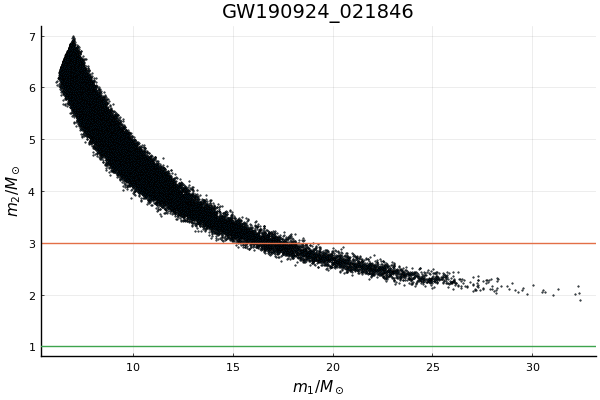

In [11]:
event = "190924_021846"
    
println(event)
post_file = "LIGO-data/masses_source_frame_posterior/GW$(event)_posterior.txt"
post = readdlm(post_file);
pyplot()
scatter(post[:, 1], post[:, 2], markersize=0.5)
hline!([3], leg=false)
hline!([1], leg=false)
xlabel!(L"m_1/M_\odot")
ylabel!(L"m_2/M_\odot")
title!("GW$event")

## LIGO data

In [12]:
# function log_pR_func(mc, σc, f, post)
#     int0(m1, m2) = mergerRateDensity(m1, m2, mc, σc, f) * post(m1, m2)
#     int(m1, m2) = δm^2 * int0(m_min + δm * m1, m_min + δm * m2)
#     function integrand(x, f)
#         f[1] = int(x[1], x[2])
#     end
#     result, err = cuhre(integrand, rtol=1e-1)
#     log(0.5 * abs(result[1]))
# end

In [13]:
function log_pR_func_1st(mc, σc, f, post)
    int0(m1, m2) = mergerRateDensity1st(m1, m2, mc, σc, f) * post(m1, m2)
    int(m1, m2) = δm^2 * int0(m_min + δm * m1, m_min + δm * m2)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    log(0.5 * abs(result[1]))
end

function log_pR_func_2nd(mc, σc, f, post)
    
    int00(i, j, e) = 1009.5488113544313 * f^(69/37) * i^(6/37) * (i+j)^(72/37) / j^(68/37) / σc^3 * exp(-(-3318*σc^4 + 1369*log(j/mc)^2)/(2738*σc^2)) * exp(-(1369*log(e/mc)^2 + 1369*log((-e+i)/mc)^2)/(2738*σc^2)) / (e^2 * (-e + i)^2) * post(i, j)
#     int0(i, j, e) = 0.5 * (int00(i, j, e) + int00(j, i, e))
    int(i, j, e) = δm^2 * (m_min + δm * i) * int00(m_min + δm * i, m_min + δm * j, (m_min + δm * i)*e)
    function integrand(x, f)
        f[1] = int(x[1], x[2], x[3])
    end
    result, err = cuhre(integrand, 3, 1, rtol=1e-1)
    result[1]
end

log_pR_func(mc, σc, f, post) = log_pR_func_1st(mc, σc, f, post) + log_pR_func_2nd(mc, σc, f, post)

log_pR_func (generic function with 1 method)

In [14]:
@time log_pR_func_1st(mc, σc, f, posts[8])

  0.060269 seconds (180.56 k allocations: 10.871 MiB, 99.15% compilation time)


-8.218407946793164

In [15]:
@time log_pR_func_2nd(mc, σc, f, posts[8])

  0.057096 seconds (206.31 k allocations: 12.251 MiB, 97.74% compilation time)


6.973043678504772e-5

In [16]:
@time log_pR_func(mc, σc, f, posts[8])

  0.017968 seconds (80.09 k allocations: 4.571 MiB, 90.55% compilation time)


-8.21833821635638

In [17]:
function logL(mc, σc, log_fpbh, posts)
    - β_func(mc, σc, 10.0^log_fpbh) + sum(log_pR_func.(mc, σc, 10.0^log_fpbh, posts))
end

logL (generic function with 1 method)

In [18]:
@btime logL(mc, σc, -3, posts)

  100.649 ms (1325379 allocations: 60.46 MiB)


-431.625635616547

In [20]:
logL(17.068251251921872, 0.11702570160808631, -2.871914894259725, posts)

-844.4042118410274

## mcmc

In [18]:
true_par_values = (mc=mc, σc=σc, log_fpbh=-3)
likelihood(true_par_values)

LogDVal{Float64}(-430.43927699224326)

In [ ]:
@time begin
println("Start sampling.")

burnin = MCMCMultiCycleBurnin(max_ncycles=1000)
samples, chains = bat_sample(posterior, MCMCSampling(mcalg=MetropolisHastings(), nsteps=10^5, nchains=4, burnin = burnin));
    
println(" ")
println("Finish sampling.")
end

save("backup/samples_$model.jld2", Dict("samples" => samples, "chains" => chains))

Start sampling.


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 fi

In [ ]:
samples = load("backup/samples_$model.jld2")["samples"];

In [ ]:
plot(samples)

In [ ]:
plot(
    samples, :σc,
    mean = true, std = true, globalmode = true, marginalmode = true,
    nbins = 50, title = "Marginalized Distribution for y"
)

In [ ]:
sd = SampledDensity(posterior, samples)
display(sd)

In [ ]:
get_post(para, samples) = [a[para] for a in samples.v]

In [ ]:
log_p1_posts = get_post(:log_p1, samples)
log_p2_posts = get_post(:log_p2, samples)
log_p3_posts = get_post(:log_p3, samples)
log_p4_posts = get_post(:log_p4, samples)
log_fpbh_posts = get_post(:log_fpbh, samples)

p1_posts = 10 .^ log_p1_posts
p2_posts = 10 .^ log_p2_posts
p3_posts = 10 .^ log_p3_posts
p4_posts = 10 .^ log_p4_posts
fpbh_posts = 10 .^ log_fpbh_posts

p5_posts = get_p5.(p1_posts, p2_posts, p3_posts, p4_posts);
log_p5_posts = log10.(p5_posts);

In [ ]:
p1_fpbh_posts = p1_posts .* fpbh_posts
p2_fpbh_posts = p2_posts .* fpbh_posts
p3_fpbh_posts = p3_posts .* fpbh_posts
p4_fpbh_posts = p4_posts .* fpbh_posts
p5_fpbh_posts = p5_posts .* fpbh_posts;

log_p1_fpbh_posts = log10.(p1_fpbh_posts)
log_p2_fpbh_posts = log10.(p2_fpbh_posts)
log_p3_fpbh_posts = log10.(p3_fpbh_posts)
log_p4_fpbh_posts = log10.(p4_fpbh_posts)
log_p5_fpbh_posts = log10.(p5_fpbh_posts);

In [ ]:
# R_posts = zeros(length(p1_posts))
# Threads.@threads for i in 1:length(R_posts)
#     R_posts[i] = merger_rate(p1_posts[i], p2_posts[i], p3_posts[i], p4_posts[i], fpbh_posts[i])
# end

# save("backup/R_posts_$model.jld2", Dict("samples" => R_posts))
R_posts = load("backup/R_posts_$model.jld2")["samples"];

In [ ]:
histogram(log_p2_posts)

In [ ]:
histogram(p1_fpbh_posts)

In [ ]:
get_quantile(posts) = quantile(posts, [0.05, 0.5, 0.95])

In [ ]:
function get_σ(posts)
    x_low, x_mid, x_up = get_quantile(posts)
    x_mid, max(x_up - x_mid, x_mid - x_low)
end
[1, get_σ(p1_fpbh_posts)...]

In [ ]:
function get_interval(posts)
    x_low, x_mid, x_up = get_quantile(posts)
    x_mid, x_up - x_mid, x_mid - x_low
end

In [ ]:
get_interval(p1_posts)

In [ ]:
get_interval(p2_posts)

In [ ]:
get_interval(p3_posts)

In [ ]:
get_interval(p4_posts)

In [ ]:
get_interval(fpbh_posts)

In [ ]:
get_interval(R_posts)

In [ ]:
get_quantile(R_posts)

In [ ]:
function get_fpbh_from_R(p1, p2, p3, p4, q)
    func = fpbh -> merger_rate(p1, p2, p3, p4, fpbh) - quantile(R_posts, q)
    find_zero(func, (1e-4, 1e-2))
end

get_fpbh_from_R(p1, p2, p3, p4, 0.05)

In [ ]:
p1_qs = get_quantile(p1_posts)
p2_qs = get_quantile(p2_posts)
p3_qs = get_quantile(p3_posts)
p4_qs = get_quantile(p4_posts)
p5_qs = get_quantile(p5_posts)
fpbh_qs = get_quantile(fpbh_posts)

p1_fpbh_qs = get_quantile(p1_fpbh_posts)
p2_fpbh_qs = get_quantile(p2_fpbh_posts)
p3_fpbh_qs = get_quantile(p3_fpbh_posts)
p4_fpbh_qs = get_quantile(p4_fpbh_posts)
p5_fpbh_qs = get_quantile(p5_fpbh_posts)

In [ ]:
ps_data = [
    [(1+3)/2, get_σ(p1_fpbh_posts)...],
    [(3+10)/2, get_σ(p2_fpbh_posts)...],
    [(10+40)/2, get_σ(p3_fpbh_posts)...],
    [(40+80)/2, get_σ(p4_fpbh_posts)...],
    [(80+130)/2, get_σ(p5_fpbh_posts)...]
]

save("backup/$(model)_ps.jld2", Dict("ps" => ps_data))

In [ ]:
function plot_band(low, mid, upper, left, right)
    ms = left:0.1:right
    pm_low = [low for m in ms]
    pm_mid = [mid for m in ms]
    pm_upper = [upper for m in ms]
    
    plot!(ms, pm_mid, label="", color="blue")
    plot!(ms, pm_low, fillrange=pm_upper, fillalpha=0.35, color="cyan", label="")
end


In [ ]:
# function Pm_log(σ, Mc, m)
#     1/m/σ/sqrt(2pi) * exp(- log(m/Mc)^2/2/σ^2)
# end

# best_lognormal(m) = Pm_log(0.58, 18.18, m)

# using Plots

# ms = 1:0.1:130
# ps = best_lognormal.(ms)

# plot(ms, ps, xaxis=:log, yaxis=:log, color="red", label="Log-normal", legend=:bottomleft)
# plot_band(p1_qs..., 1, 5)
# plot_band(p2_qs..., 5, 10)
# plot_band(p3_qs..., 10, 40)
# plot_band(p4_qs..., 40, 80)
# plot_band(p5_qs..., 80, 130)
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"P(m)")

In [ ]:
# function lognormal(σ, Mc, m)
#     1/m/σ/sqrt(2pi) * exp(- log(m/Mc)^2/2/σ^2)
# end

# best_lognormal(m) = lognormal(0.58, 18.18, m)

# using Plots

# ms = [(1+5)/2, (5+10)/2, (10+40)/2, (40+80)/2, (80+130)/2]
# ps = PmQCD.(ms, 10^(-2.26092), -0.0639596)

# plot(ms, ps, xaxis=:log, yaxis=:log, color="black", legend=:bottomleft)
# plot_band(p1_fpbh_qs..., 1, 5)
# plot_band(p2_fpbh_qs..., 5, 10)
# plot_band(p3_fpbh_qs..., 10, 40)
# plot_band(p4_fpbh_qs..., 40, 80)
# plot_band(p5_fpbh_qs..., 80, 130)
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"f_\mathrm{pbh} P(m)")

In [ ]:
# # using StatsPlots # no need for `using Plots` as that is reexported here
# # pyplot()
# ms = [(1+5)/2 (5+10)/2 (10+40)/2 (40+80)/2 (80+130)/2]
# ps = [p1_posts, p2_posts, p3_posts, p4_posts, p5_posts]

# violin(ms[1], ps[1], leg=false, linewidth=0, xlim=[1, 130], xaxis=:log, yaxis=:log, color="red")
# # for i in 2:5
# #     violin!(ms[i], ps[i], leg=false, linewidth=0, xlim=[1, 130], xaxis=:log, yaxis=:log, color="red", widths=1e2)
# # end
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"P(m)")

In [ ]:
# using StatsPlots # no need for `using Plots` as that is reexported here
# pyplot()

In [ ]:
function get_err(end_points)
    left_points = end_points[1:end-1]
    right_points = end_points[2:end]
    mean_points = (left_points .+ right_points) ./ 2
    left_err = mean_points - left_points
    right_err = right_points - mean_points
    mean_points, left_err, right_err
end

## merger rate

In [ ]:
post_190521 = get_post_func("190521")
post_200115 = get_post_func("200115_042309")
post_200105 = get_post_func("200105_162426")

post_190814 = get_post_func("190814")
post_190425 = get_post_func("190425")
post_190426 = get_post_func("190426_152155")

In [ ]:
ms = 22:0.1:27
ms2 = 2.2:0.0005:2.6
# ps = post_190814.(ms2, 1.58)
ps = post_190814.(ms, 2.5)
# ps2 = post_200115.(5.7, ms)
# ps3 = post_200105.(5.7, ms)
plot(ms, ps)
# plot!(ms, ps3)

In [ ]:
thr = 7.708648380664132e-5;
function get_area(thr, post_data)
    post, m1_min, m1_max, m2_min, m2_max = post_data
    δm1 = m1_max - m1_min
    δm2 = m2_max - m2_min
    
    function post_new(m1, m2)
        p = post(m1, m2)
        p >= thr ? p : 0
    end
    int(m1, m2) = δm1 * δm2 * post_new(m1_min + δm1*m1, m2_min + δm2*m2)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3, minevals=1e4)
    result[1]
end

function get_thr(post_data)
    fzero(thr -> get_area(thr, post_data) - 0.9, 1e-5, 1e2)
end
    
function get_cond_merger_rate(p1, p2, p3, p4, fpbh, post_data, thr)
    post, m1_min, m1_max, m2_min, m2_max = post_data
    δm1 = m1_max - m1_min
    δm2 = m2_max - m2_min
#     println(δm1)
#     println(δm2)
    
    R12_new(m1, m2) = post(m1, m2) >= thr ? R12(m1, m2, p1, p2, p3, p4, fpbh) : 0
    int(m1, m2) = δm1 * δm2 * R12_new(m1_min + δm1*m1, m2_min + δm2*m2)
#     println("p1=$p10, p2=$p20, p3=$p30")
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    result[1]
end

# function get_cond_merger_rate2(p1, p2, p3, p4, fpbh, post_data, thr)
#     post, m1_min, m1_max, m2_min, m2_max = post_data
#     δm1 = m1_max - m1_min
#     δm2 = m2_max - m2_min
# #     println(δm1)
# #     println(δm2)
    
#     R12_new(m1, m2) = R12(m1, m2, p1, p2, p3, p4, fpbh)
#     int(m1, m2) = δm1 * δm2 * R12_new(m1_min + δm1*m1, m2_min + δm2*m2)
# #     println("p1=$p10, p2=$p20, p3=$p30")
#     function integrand(x, f)
#         f[1] = int(x[1], x[2])
#     end
#     result, err = cuhre(integrand, rtol=1e-1)
#     result[1]
# end

In [ ]:
# post_data = [post_200105, 6, 12, 1.5, 2.5];
post_data = [post_190814, 20, 30, 1, 3];
thr = get_thr(post_data)
println(thr)
println(get_area(thr, post_data))

i = 10
@time get_cond_merger_rate(p1_posts[i], p2_posts[i], p3_posts[i], p4_posts[i], fpbh_posts[i], post_data, thr)

In [ ]:
get_cond_merger_rate(p1_qs[2], p2_qs[2], p3_qs[2], p4_qs[2], fpbh_qs[2], post_data, thr)

In [ ]:
function get_R_post(post_data)
    len = length(p1_posts)
    result = zeros(len)
    thr = get_thr(post_data)
    println(thr)
    Threads.@threads for i in 1:len
#     for i in 1:len
        result[i] = get_cond_merger_rate(p1_posts[i], p2_posts[i], p3_posts[i], p4_posts[i], fpbh_posts[i], post_data, thr)
#         println(result[i])
    end
    result
end

In [ ]:
@time R_post_190521 = get_R_post([post_190521, 10, 130, 10, 130]);
save("backup/$(model)_R_post_190521.jld2", Dict("posts" => R_post_190521))

R_post = load("backup/$(model)_R_post_190521.jld2")["posts"];
get_interval(R_post)